# Blackjack Implementation

Assumptions:
- Drawing from an infinite deck (doesn't matter if we count cards)
- Useable Ace vs Ace

In [196]:
import numpy as np

class Player():
    def __init__(self, name="Player"):
        self.name = name
        self.cards = np.array([], dtype="int")
        self.hit(2)
    
    def value(self):
        hand_sum = np.sum(self.cards)
        if 1 not in self.cards:
            return (hand_sum, False)

        aces = np.bincount(self.cards)[1]
        usable_ace = hand_sum - (aces - 1) <= 10
        if usable_ace:
            return (hand_sum + 10, True)
        
        return (hand_sum, False)
        
    def hit(self, n=1):
        for i in range(n):
            random_card = np.random.choice([x for x in range(1, 11)], 1, p=[1/13 for x in range(1, 10)] + [4/13])
            self.cards = np.append(self.cards, [random_card])

    def bust(self):
        return self.value()[0] > 21

In [386]:
class Blackjack():
    def __init__(self):
        self.player = Player("Player")
        self.dealer = Player("Dealer")

    def reward(self):
        if self.player.bust():
            return -1

        if self.dealer.bust():
            return 1

        if self.player.value()[0] == self.dealer.value()[0]:
            return 0

        if self.player.value()[0] > self.dealer.value()[0]:
            return 1

        return -1
    
    def play(self, policy):
        episode = []

        # Player's Turn
        state = None
        player_hit = False
        while True:
            p_val, useable_ace = self.player.value()
            state = (p_val, useable_ace, self.dealer.cards[0])
            player_hit = policy.action(state)
            print(player_hit)
            if player_hit:
                self.player.hit()
                if self.player.bust():
                    episode.append((state, player_hit, -1))
                    return episode
                episode.append((state, player_hit, 0))
                continue
            break
        
        # Dealer's Turn
        while True:
            dealer_hit = self.dealer.value()[0] < 17
            if dealer_hit:
                self.dealer.hit()
                if self.dealer.bust():
                    break
                continue
            break

        episode.append((state, player_hit, self.reward()))
        return episode

# Monte Carlo

## Variations
- Exploring Starts (for pi)
    - First-Visit MC (for v)
    - Every-Visit MC (for v)
- On-Policy MC Control (for pi)
    - First-Visit MC (for v)
    - Every-Visit MC (for v)
- Off-Policy (for pi) (Importance Sampling)
    - MC Control
    - Incremental Implementation

In [311]:
class BehaviorPolicy():
    def __init__(self):
        self.p = 0.5

    def action_prob(self, state, action):
        if state[0] < 12:
            return 1
        return self.p

    def action(self, state):
        if state[0] < 12:
            return 1
        return np.random.uniform(0, 1) < self.p

class TargetPolicy():
    def __init__(self, Q):
        self.p = np.random.uniform(0, 1, Q.shape)
        aArgmax = np.argmax(self.p, axis=3)
        i, j, k = np.indices(aArgmax.shape)

        self.p = np.zeros(Q.shape)
        self.p[i, j, k, aArgmax] = 1
        
    def action_prob(self, state, action):
        player_value, usable_ace, dealer_showing = state
        if player_value < 12:
            return 1
        return self.p[player_value, int(usable_ace), dealer_showing, action]
        
    def action(self, state):
        player_value, usable_ace, dealer_showing = state
        if player_value < 12:
            return 1
        return np.argmax(self.p[player_value, int(usable_ace), dealer_showing])

In [368]:
class MonteCarlo():
    def __init__(self, behavior = None, target = None):
        self.Q = np.zeros((22, 2, 11, 2))
        self.C = np.zeros((22, 2, 11, 2))
        self.gamma = 1
        
        self.b = BehaviorPolicy()
        if behavior:
            self.b = behavior

        self.pi = TargetPolicy(self.Q)
        if target:
            self.pi = target

    def estimate(self, n_episodes=1000):
        for i in range(n_episodes):
            if(i % (n_episodes / 20) == 0):
                print(f"Episode {i}/{n_episodes}")
                
            game = Blackjack()
            episode = game.play(self.b)
            
            G = 0
            W = 1
            for (index, turn) in reversed(list(enumerate(episode))):
                S, A, R = turn
                player_v, usable_ace, dealer_showing = S
                
                A = int(A)
                usable_ace = int(usable_ace)
                
                G = self.gamma * G + R
                C = self.C[player_v, usable_ace, dealer_showing, A]
                self.C[player_v, usable_ace, dealer_showing, A] = C + W

                Q = self.Q[player_v, usable_ace, dealer_showing, A]
                C = self.C[player_v, usable_ace, dealer_showing, A]
                self.Q[player_v, usable_ace, dealer_showing, A] = Q + (W / C) * (G - Q)

                aArgmax = np.argmax(self.Q[player_v, usable_ace, dealer_showing])
                self.pi.p[player_v, usable_ace, dealer_showing] = [0, 0]
                self.pi.p[player_v, usable_ace, dealer_showing, aArgmax] = 1

                if int(A) != aArgmax:
                    break

                W = W / self.b.action_prob(S, int(A))

        return self.pi

In [372]:
learner = MonteCarlo()
initial_policy = learner.pi

n = 10000
reward = 0
for i in range(n):
    game = Blackjack()
    episode = game.play(learner.pi)
    reward += episode[-1][2]
print('Initial Policy Average Reward', reward / n)

Initial Policy Average Reward -0.3644


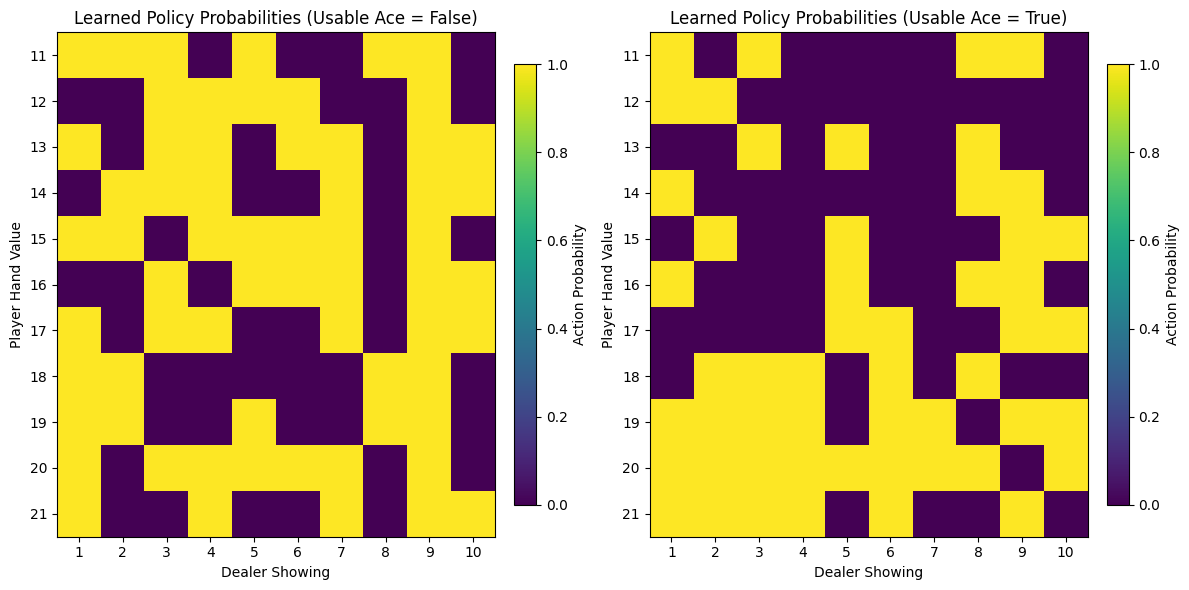

In [373]:
# Assuming learned_policy is the policy object returned after learning
policy_matrix_no_ace = initial_policy.p[11:, 0, 1:, 0]
policy_matrix_usable_ace = initial_policy.p[11:, 1, 1:, 0]

# Create subplots
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Plot the policy matrix without usable ace
ax = axes[0]
im = ax.imshow(policy_matrix_no_ace, cmap="viridis", aspect='auto')
ax.set_title('Learned Policy Probabilities (Usable Ace = False)')
ax.set_xlabel('Dealer Showing')
ax.set_ylabel('Player Hand Value')
ax.set_xticks(range(0, 10))
ax.set_xticklabels([str(i) for i in range(1, 11)])
ax.set_yticks(range(0, 11))
ax.set_yticklabels([str(i) for i in range(11, 22)])

# Add colorbar
cbar = plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
cbar.set_label('Action Probability')

# Plot the policy matrix with usable ace
ax = axes[1]
im = ax.imshow(policy_matrix_usable_ace, cmap="viridis", aspect='auto')
ax.set_title('Learned Policy Probabilities (Usable Ace = True)')
ax.set_xlabel('Dealer Showing')
ax.set_ylabel('Player Hand Value')
ax.set_xticks(range(0, 10))
ax.set_xticklabels([str(i) for i in range(1, 11)])
ax.set_yticks(range(0, 11))
ax.set_yticklabels([str(i) for i in range(11, 22)])

# Add colorbar
cbar = plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
cbar.set_label('Action Probability')

# Adjust layout
plt.tight_layout()

# Show the plot
plt.show()

In [374]:
learned_policy = learner.estimate(1000000)

Episode 0/1000000
Episode 50000/1000000
Episode 100000/1000000
Episode 150000/1000000
Episode 200000/1000000
Episode 250000/1000000
Episode 300000/1000000
Episode 350000/1000000
Episode 400000/1000000
Episode 450000/1000000
Episode 500000/1000000
Episode 550000/1000000
Episode 600000/1000000
Episode 650000/1000000
Episode 700000/1000000
Episode 750000/1000000
Episode 800000/1000000
Episode 850000/1000000
Episode 900000/1000000
Episode 950000/1000000


In [375]:
reward = 0
for i in range(n):
    game = Blackjack()
    episode = game.play(learned_policy)
    reward += episode[-1][2]
print('Learned Policy Average Reward', reward / n)

Learned Policy Average Reward -0.051


In [387]:
test = Blackjack()
test.player.cards = [1, 1]
test.dealer.cards = [5, 4]
episode = test.play(learned_policy)
print(episode)

1
1
0
[((11, False, 5), 1, 0), ((12, False, 5), 1, 0), ((13, False, 5), 0, -1)]


In [389]:
print(learned_policy.p[11, 0, 5, :])
print(np.argmax(learned_policy.p[11, 0, 5]))

[0. 1.]
1


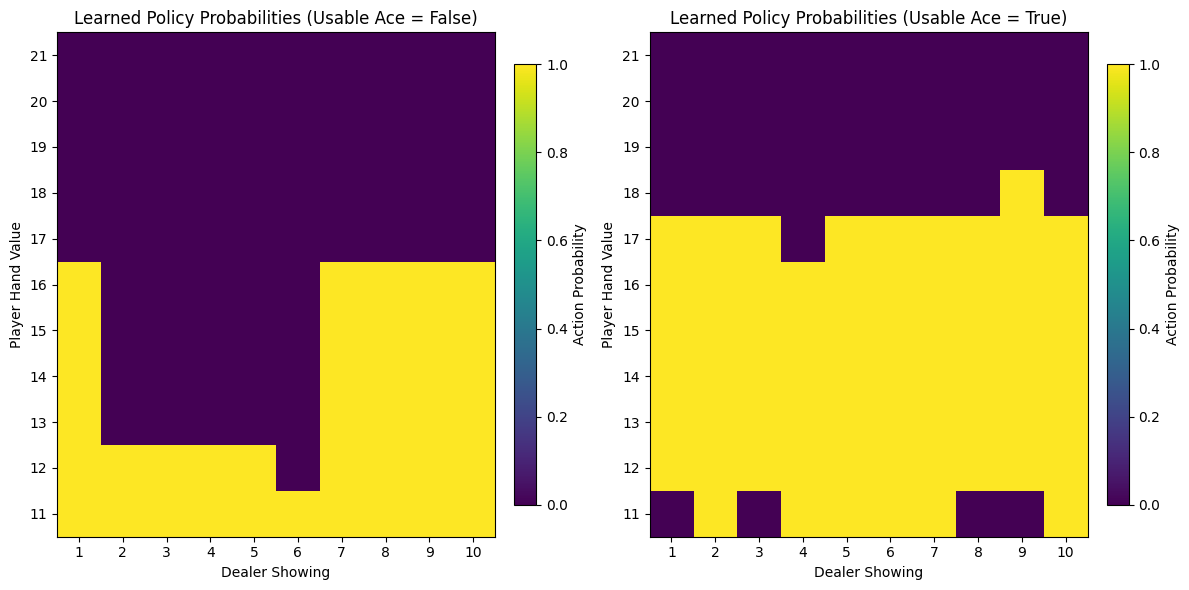

In [400]:
import matplotlib.pyplot as plt

# Assuming learned_policy is the policy object returned after learning
policy_matrix_no_ace = learned_policy.p[11:, 0, 1:, 1]
policy_matrix_usable_ace = learned_policy.p[11:, 1, 1:, 1]

# Create subplots
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Plot the policy matrix without usable ace
ax = axes[0]
im = ax.imshow(policy_matrix_no_ace, cmap="viridis", aspect='auto')
ax.set_title('Learned Policy Probabilities (Usable Ace = False)')
ax.set_xlabel('Dealer Showing')
ax.set_ylabel('Player Hand Value')
ax.set_xticks(range(0, 10))
ax.set_xticklabels([str(i) for i in range(1, 11)])
ax.set_yticks(range(0, 11))
ax.set_yticklabels([str(i) for i in range(11, 22)])
ax.invert_yaxis()  # Flip the y-axis

# Add colorbar
cbar = plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
cbar.set_label('Action Probability')

# Plot the policy matrix with usable ace
ax = axes[1]
im = ax.imshow(policy_matrix_usable_ace, cmap="viridis", aspect='auto')
ax.set_title('Learned Policy Probabilities (Usable Ace = True)')
ax.set_xlabel('Dealer Showing')
ax.set_ylabel('Player Hand Value')
ax.set_xticks(range(0, 10))
ax.set_xticklabels([str(i) for i in range(1, 11)])
ax.set_yticks(range(0, 11))
ax.set_yticklabels([str(i) for i in range(11, 22)])
ax.invert_yaxis()  # Flip the y-axis

# Add colorbar
cbar = plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
cbar.set_label('Action Probability')

# Adjust layout
plt.tight_layout()

# Show the plot
plt.show()

# Temporal Difference

## Sarsa

## Q-Learning

## Expected Sarsa